# Identifying Credit Card Fraud - Modeling

## Introduction

### Scenario:

Our goal is to approach this as an actual business problem, to the best of our ability.  Unfortunately, given the nature of this project, there is no actual "client" or "customer" where we can discuss and properly assess the objectives of our solution.  As a result, I've consulted with my mentor and we have put forth the following scenario:

- We will set our objective to be to catch as many fraudulent transactions as possible, at the expense of incorrectly labeling some valid transactions as fraud (false positives). 
- With that said, we want to avoid having an exorbitant amount of false positives because that can become a major nuisance to consumers.
- We want to maximize <b>recall</b>, while still keeping an eye on <b>precision</b>.
- As a result, our goal wfill be to optimize the <b>f1-score</b>.


### Plan:

In our previous notebook, we generated a baseline model that with poor performance due to the highly imbalanced nature of classes in this dataset.  In this notebook, we plan on dealing with the imbalance so that we can train more effective models.  We will try multiple combinations of sampling methods and algorithms to construct multiple models to compare.  

As for sampling methods, we will try random undersampling and random oversampling. A drawback of these two methods is that random undersampling of the majority class can potentially remove important data points, and random oversampling of the minority class can lead to overfitting.  As a result, we will also try to synthetically generate samples that are similar to the minority class distribution using SMOTE.  And finally, we will also try the "class_weight" parameter in each of the models to balance the weight of the majority and minority classes.

Speaking of models, we will try Logistic Regression, Random Forest, and XGBoost. In order to compare, our end goal will be to construct a table such as this:


| Algorithm | Class Balance | Train Precision | Train Recall | Train f1-score | Train Support | Test Precision | Test Recall | Test f1-score | Test Support |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| <b>Logistic Regression</b> | Undersample majority | ? | ? | ? | ? | ? | ? | ? | ? |
| | Oversample minority | ? | ? | ? | ? | ? | ? | ? | ? |
| | SMOTE | ? | ? | ? | ? | ? | ? | ? | ? |
| | class_weight balance | ? | ? | ? | ? | ? | ? | ? | ? |
| <b>Random Forest</b> | Undersample majority | ? | ? | ? | ? | ? | ? | ? | ? |
| | Oversample minority | ? | ? | ? | ? | ? | ? | ? | ? |
| | SMOTE | ? | ? | ? | ? | ? | ? | ? | ? |
| | class_weight balance | ? | ? | ? | ? | ? | ? | ? | ? |
| <b>XGboost</b> | Undersample majority | ? | ? | ? | ? | ? | ? | ? | ? |
| | Oversample minority | ? | ? | ? | ? | ? | ? | ? | ? |
| | SMOTE | ? | ? | ? | ? | ? | ? | ? | ? |
| | class_weight balance | ? | ? | ? | ? | ? | ? | ? | ? |



## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
X_train = pd.read_csv('../raw_data/X_train_scaled.csv', index_col=0)
X_test = pd.read_csv('../raw_data/X_test_scaled.csv', index_col=0)
y_train = pd.read_csv('../raw_data/y_train.csv', index_col=0)
y_test = pd.read_csv('../raw_data/y_test.csv', index_col=0)

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1481794 entries, 0 to 1481793
Data columns (total 31 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   amt                 1481794 non-null  float64
 1   city_pop            1481794 non-null  float64
 2   abnormal_hours      1481794 non-null  float64
 3   time_diff           1481794 non-null  float64
 4   count_24_hour       1481794 non-null  float64
 5   count_7_days        1481794 non-null  float64
 6   count_30_days       1481794 non-null  float64
 7   gender_M            1481794 non-null  float64
 8   dist_haversine      1481794 non-null  float64
 9   age                 1481794 non-null  float64
 10  cat_entertainment   1481794 non-null  float64
 11  cat_food_dining     1481794 non-null  float64
 12  cat_gas_transport   1481794 non-null  float64
 13  cat_grocery_net     1481794 non-null  float64
 14  cat_grocery_pos     1481794 non-null  float64
 15  cat_health_fitn

In [4]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370449 entries, 0 to 370448
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   amt                 370449 non-null  float64
 1   city_pop            370449 non-null  float64
 2   abnormal_hours      370449 non-null  float64
 3   time_diff           370449 non-null  float64
 4   count_24_hour       370449 non-null  float64
 5   count_7_days        370449 non-null  float64
 6   count_30_days       370449 non-null  float64
 7   gender_M            370449 non-null  float64
 8   dist_haversine      370449 non-null  float64
 9   age                 370449 non-null  float64
 10  cat_entertainment   370449 non-null  float64
 11  cat_food_dining     370449 non-null  float64
 12  cat_gas_transport   370449 non-null  float64
 13  cat_grocery_net     370449 non-null  float64
 14  cat_grocery_pos     370449 non-null  float64
 15  cat_health_fitness  370449 non-nul

In [5]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1481794 entries, 572842 to 269493
Data columns (total 1 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   is_fraud  1481794 non-null  int64
dtypes: int64(1)
memory usage: 22.6 MB


In [6]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370449 entries, 1634393 to 1228030
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   is_fraud  370449 non-null  int64
dtypes: int64(1)
memory usage: 5.7 MB


In [7]:
y_train.value_counts()

is_fraud
0           1474073
1              7721
dtype: int64

In [8]:
y_test.value_counts()

is_fraud
0           368519
1             1930
dtype: int64

## Resampling

First, we'll create a dataframe with the counts of observations in X_train, y_train, as well as the counts of each class of the target variable "is_fraud".

In [9]:
counts_table = pd.DataFrame()

counts_table['technique'] = ['Original Data']
counts_table['X_train_shape'] = [X_train.shape[0]]
counts_table['y_train_shape'] = [y_train.shape[0]]
counts_table['is_fraud_0'] = [y_train.value_counts()[0]]
counts_table['is_fraud_1'] = [y_train.value_counts()[1]]

counts_table

,technique,X_train_shape,y_train_shape,is_fraud_0,is_fraud_1
0,Original Data,1481794,1481794,1474073,7721


#### Undersampling

We'll create new variables for X_train, y_train after they have been undersampled using RandomUnderSampler.

In [10]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)

X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

Next, we'll create a new row in our counts_table dataframe and append the counts.

In [11]:
new_row = {'technique':'Random Under Sampling', 
           'X_train_shape': X_train_rus.shape[0],
          'y_train_shape': y_train_rus.shape[0],
           'is_fraud_0': y_train_rus.value_counts()[0],
          'is_fraud_1': y_train_rus.value_counts()[1]}

counts_table = counts_table.append(new_row, ignore_index=True)
counts_table

,technique,X_train_shape,y_train_shape,is_fraud_0,is_fraud_1
0,Original Data,1481794,1481794,1474073,7721
1,Random Under Sampling,15442,15442,7721,7721


#### Oversampling

We'll create new variables for X_train, y_train after they have been oversampled using RandomOversampler.

In [12]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

X_train_ros, y_train_ros = ros.fit_sample(X_train, y_train)

In [13]:
new_row = {'technique':'Random Over Sampling', 
           'X_train_shape': X_train_ros.shape[0],
          'y_train_shape': y_train_ros.shape[0],
           'is_fraud_0': y_train_ros.value_counts()[0],
          'is_fraud_1': y_train_ros.value_counts()[1]}

counts_table = counts_table.append(new_row, ignore_index=True)
counts_table

,technique,X_train_shape,y_train_shape,is_fraud_0,is_fraud_1
0,Original Data,1481794,1481794,1474073,7721
1,Random Under Sampling,15442,15442,7721,7721
2,Random Over Sampling,2948146,2948146,1474073,1474073


#### SMOTE

We'll create new variables for X_train, y_train after SMOTE

In [14]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, sampling_strategy = 'minority')

X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

In [15]:
new_row = {'technique':'SMOTE - minority', 
           'X_train_shape': X_train_sm.shape[0],
          'y_train_shape': y_train_sm.shape[0],
           'is_fraud_0': y_train_sm.value_counts()[0],
          'is_fraud_1': y_train_sm.value_counts()[1]}

counts_table = counts_table.append(new_row, ignore_index=True)
counts_table

,technique,X_train_shape,y_train_shape,is_fraud_0,is_fraud_1
0,Original Data,1481794,1481794,1474073,7721
1,Random Under Sampling,15442,15442,7721,7721
2,Random Over Sampling,2948146,2948146,1474073,1474073
3,SMOTE - minority,2948146,2948146,1474073,1474073


Convert dataframes to numpy arrays.

In [16]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy().ravel()
X_train_rus_np = X_train_rus.to_numpy()
y_train_rus_np = y_train_rus.to_numpy().ravel()
X_train_ros_np = X_train_ros.to_numpy()
y_train_ros_np = y_train_ros.to_numpy().ravel()
X_train_sm_np = X_train_sm.to_numpy()
y_train_sm_np = y_train_sm.to_numpy().ravel()

X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy().ravel()

In [17]:
print(X_train_np.shape, y_train_np.shape)
print(X_train_rus_np.shape, y_train_rus_np.shape)
print(X_train_ros_np.shape, y_train_ros_np.shape)
print(X_train_sm_np.shape, y_train_sm_np.shape)

(1481794, 31) (1481794,)
(15442, 31) (15442,)
(2948146, 31) (2948146,)
(2948146, 31) (2948146,)


## Setting up table for model metric comparison

In [18]:
column_names = ["Algorithm", "Class Balancing", "Train Precision", "Train Recall", "Train f1", "Train Support", "Test Precision", "Test Recall", "Test f1", "Test Support"]

metrics = pd.DataFrame(columns = column_names)

We'll define a function that will take metrics from classification report and add them to this table.

In [19]:
def add_metrics(algorithm, class_balancing, train_report, test_report):
    new_row = {'Algorithm':algorithm,
              'Class Balancing':class_balancing,
              'Train Precision': train_report['fraud']['precision'],
              'Train Recall': train_report['fraud']['recall'],
              'Train f1': train_report['fraud']['f1-score'],
              'Train Support': train_report['fraud']['support'],
              'Test Precision': test_report['fraud']['precision'],
              'Test Recall': test_report['fraud']['recall'],
              'Test f1': test_report['fraud']['f1-score'],
              'Test Support': test_report['fraud']['support']}
    
    global metrics
    
    metrics = metrics.append(new_row, ignore_index = True)

## Algorithm 1: Logistic Regression

### 1a) with Random Under Sampling
We'll begin by applying a baseline logistic regression to the random UNDER sampled data.

In [20]:
from sklearn.linear_model import LogisticRegression

lr_rus = LogisticRegression(solver = 'saga', random_state=42)
# Fit the model on the trainng data.
lr_rus.fit(X_train_rus_np, y_train_rus_np)

y_pred_train_1a = lr_rus.predict(X_train_rus_np)
y_pred_test_1a = lr_rus.predict(X_test_np)

In [21]:
cm_1a_train = confusion_matrix(y_train_rus_np, y_pred_train_1a)
cm_1a_test = confusion_matrix(y_test_np, y_pred_test_1a)

Text(0.5, 1.0, 'LogisticRegression RUS - Testing confusion matrix')

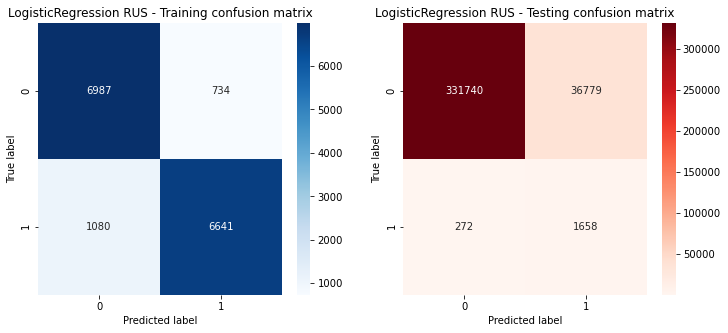

In [22]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_1a_train, annot=True, fmt = '', cmap = 'Blues',ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('LogisticRegression RUS - Training confusion matrix')

sns.heatmap(cm_1a_test, annot=True, fmt = '', cmap = 'Reds',ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('LogisticRegression RUS - Testing confusion matrix')

In [23]:
from sklearn.metrics import classification_report

target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_rus_np, y_pred_train_1a, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test_np, y_pred_test_1a, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       0.87      0.90      0.89      7721
       fraud       0.90      0.86      0.88      7721

    accuracy                           0.88     15442
   macro avg       0.88      0.88      0.88     15442
weighted avg       0.88      0.88      0.88     15442

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      0.90      0.95    368519
       fraud       0.04      0.86      0.08      1930

    accuracy                           0.90    370449
   macro avg       0.52      0.88      0.51    370449
weighted avg       0.99      0.90      0.94    370449



Create dictionary versions of classification reports and add them to metrics dataframe

In [24]:
train_report_1a = classification_report(y_train_rus_np, y_pred_train_1a, target_names=target_names, output_dict = True)
test_report_1a = classification_report(y_test_np, y_pred_test_1a, target_names=target_names, output_dict = True)

add_metrics('Logistic Regression', 'Random Under Sampling', train_report_1a, test_report_1a)
metrics

,Algorithm,Class Balancing,Train Precision,Train Recall,Train f1,Train Support,Test Precision,Test Recall,Test f1,Test Support
0,Logistic Regression,Random Under Sampling,0.900475,0.860122,0.879836,7721,0.043136,0.859067,0.082146,1930


### 1b) with Random Over Sampling

In [25]:
lr_ros = LogisticRegression(solver = 'saga', random_state=42)
# Fit the model on the trainng data.
lr_ros.fit(X_train_ros_np, y_train_ros_np)

y_pred_train_1b = lr_ros.predict(X_train_ros_np)
y_pred_test_1b = lr_ros.predict(X_test_np)

In [26]:
cm_1b_train = confusion_matrix(y_train_ros_np,y_pred_train_1b)
cm_1b_test = confusion_matrix(y_test_np,y_pred_test_1b)

Text(0.5, 1.0, 'LogisticRegression ROS - Testing confusion matrix')

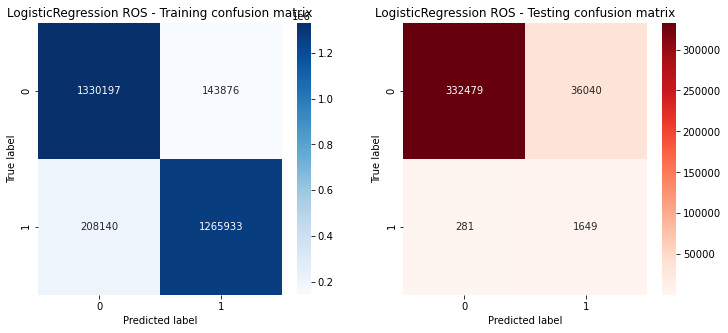

In [27]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_1b_train, annot=True, fmt = '', cmap = 'Blues',ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('LogisticRegression ROS - Training confusion matrix')

sns.heatmap(cm_1b_test, annot=True, fmt = '', cmap = 'Reds',ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('LogisticRegression ROS - Testing confusion matrix')

In [28]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_ros_np, y_pred_train_1b, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test_np, y_pred_test_1b, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       0.86      0.90      0.88   1474073
       fraud       0.90      0.86      0.88   1474073

    accuracy                           0.88   2948146
   macro avg       0.88      0.88      0.88   2948146
weighted avg       0.88      0.88      0.88   2948146

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      0.90      0.95    368519
       fraud       0.04      0.85      0.08      1930

    accuracy                           0.90    370449
   macro avg       0.52      0.88      0.52    370449
weighted avg       0.99      0.90      0.94    370449



Create dictionary versions of classification reports and add them to metrics dataframe

In [29]:
train_report_1b = classification_report(y_train_ros_np, y_pred_train_1b, target_names=target_names, output_dict = True)
test_report_1b = classification_report(y_test_np, y_pred_test_1b, target_names=target_names, output_dict = True)

add_metrics('Logistic Regression', 'Random Over Sampling', train_report_1b, test_report_1b)
metrics

,Algorithm,Class Balancing,Train Precision,Train Recall,Train f1,Train Support,Test Precision,Test Recall,Test f1,Test Support
0,Logistic Regression,Random Under Sampling,0.900475,0.860122,0.879836,7721,0.043136,0.859067,0.082146,1930
1,Logistic Regression,Random Over Sampling,0.897946,0.858799,0.877937,1474073,0.043753,0.854404,0.083243,1930


### 1c) with SMOTE

In [30]:
lr_sm = LogisticRegression(solver = 'saga', random_state=42)
# Fit the model on the trainng data.
lr_sm.fit(X_train_sm_np, y_train_sm_np)

y_pred_train_1c = lr_sm.predict(X_train_sm_np)
y_pred_test_1c = lr_sm.predict(X_test_np)

In [31]:
cm_1c_train = confusion_matrix(y_train_sm_np,y_pred_train_1c)
cm_1c_test = confusion_matrix(y_test_np,y_pred_test_1c)

Text(0.5, 1.0, 'LogisticRegression SMOTE - Testing confusion matrix')

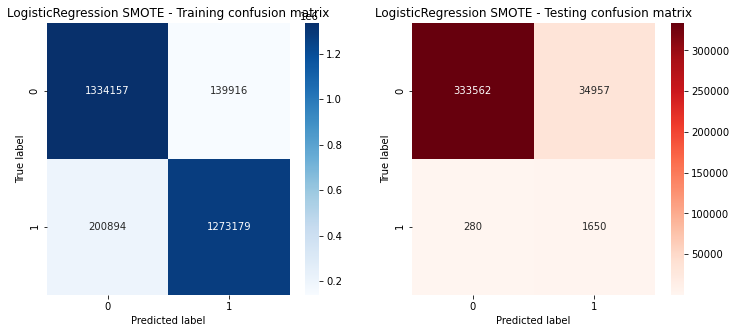

In [32]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_1c_train, annot=True, fmt = '', cmap = 'Blues',ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('LogisticRegression SMOTE - Training confusion matrix')

sns.heatmap(cm_1c_test, annot=True, fmt = '', cmap = 'Reds',ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('LogisticRegression SMOTE - Testing confusion matrix')

In [33]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_sm_np, y_pred_train_1c, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test_np, y_pred_test_1c, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       0.87      0.91      0.89   1474073
       fraud       0.90      0.86      0.88   1474073

    accuracy                           0.88   2948146
   macro avg       0.89      0.88      0.88   2948146
weighted avg       0.89      0.88      0.88   2948146

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      0.91      0.95    368519
       fraud       0.05      0.85      0.09      1930

    accuracy                           0.90    370449
   macro avg       0.52      0.88      0.52    370449
weighted avg       0.99      0.90      0.95    370449



Create dictionary versions of classification reports and add them to metrics dataframe

In [34]:
train_report_1c = classification_report(y_train_sm_np, y_pred_train_1c, target_names=target_names, output_dict = True)
test_report_1c = classification_report(y_test_np, y_pred_test_1c, target_names=target_names, output_dict = True)

add_metrics('Logistic Regression', 'SMOTE', train_report_1c, test_report_1c)
metrics

,Algorithm,Class Balancing,Train Precision,Train Recall,Train f1,Train Support,Test Precision,Test Recall,Test f1,Test Support
0,Logistic Regression,Random Under Sampling,0.900475,0.860122,0.879836,7721,0.043136,0.859067,0.082146,1930
1,Logistic Regression,Random Over Sampling,0.897946,0.858799,0.877937,1474073,0.043753,0.854404,0.083243,1930
2,Logistic Regression,SMOTE,0.900986,0.863715,0.881957,1474073,0.045073,0.854922,0.085632,1930


### 1d) with class_weight = balanced

In [35]:
lr_cw = LogisticRegression(solver = 'saga', random_state=42, class_weight='balanced')
# Fit the model on the trainng data.
lr_cw.fit(X_train_np, y_train_np)

y_pred_train_1d = lr_cw.predict(X_train_np)
y_pred_test_1d = lr_cw.predict(X_test_np)

In [36]:
cm_1d_train = confusion_matrix(y_train_np,y_pred_train_1d)
cm_1d_test = confusion_matrix(y_test_np,y_pred_test_1d)

Text(0.5, 1.0, 'LogisticRegression class_weight - Testing confusion matrix')

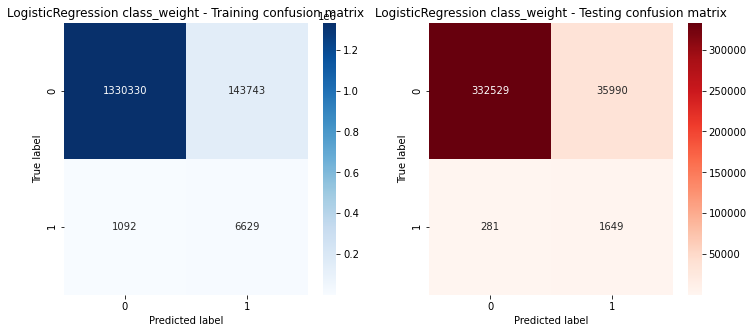

In [37]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_1d_train, annot=True, fmt = '', cmap = 'Blues',ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('LogisticRegression class_weight - Training confusion matrix')

sns.heatmap(cm_1d_test, annot=True, fmt = '', cmap = 'Reds',ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('LogisticRegression class_weight - Testing confusion matrix')

In [38]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_np, y_pred_train_1d, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test_np, y_pred_test_1d, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       1.00      0.90      0.95   1474073
       fraud       0.04      0.86      0.08      7721

    accuracy                           0.90   1481794
   macro avg       0.52      0.88      0.52   1481794
weighted avg       0.99      0.90      0.94   1481794

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      0.90      0.95    368519
       fraud       0.04      0.85      0.08      1930

    accuracy                           0.90    370449
   macro avg       0.52      0.88      0.52    370449
weighted avg       0.99      0.90      0.94    370449



Create dictionary versions of classification reports and add them to metrics dataframe

In [39]:
train_report_1d = classification_report(y_train_np, y_pred_train_1d, target_names=target_names, output_dict = True)
test_report_1d = classification_report(y_test_np, y_pred_test_1d, target_names=target_names, output_dict = True)

add_metrics('Logistic Regression', 'Balanced weight', train_report_1d, test_report_1d)
metrics

,Algorithm,Class Balancing,Train Precision,Train Recall,Train f1,Train Support,Test Precision,Test Recall,Test f1,Test Support
0,Logistic Regression,Random Under Sampling,0.900475,0.860122,0.879836,7721,0.043136,0.859067,0.082146,1930
1,Logistic Regression,Random Over Sampling,0.897946,0.858799,0.877937,1474073,0.043753,0.854404,0.083243,1930
2,Logistic Regression,SMOTE,0.900986,0.863715,0.881957,1474073,0.045073,0.854922,0.085632,1930
3,Logistic Regression,Balanced weight,0.044084,0.858568,0.083862,7721,0.043811,0.854404,0.083348,1930


## Algorithm 2: Random Forest

### 2a) with Random Under Sampling

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf_rus = RandomForestClassifier(random_state=42)
rf_rus.fit(X_train_rus_np, y_train_rus_np)

y_pred_train_2a = rf_rus.predict(X_train_rus_np)
y_pred_test_2a = rf_rus.predict(X_test_np)

In [41]:
cm_2a_train = confusion_matrix(y_train_rus_np,y_pred_train_2a)
cm_2a_test = confusion_matrix(y_test_np,y_pred_test_2a)

Text(0.5, 1.0, 'RandomForest RUS - Testing confusion matrix')

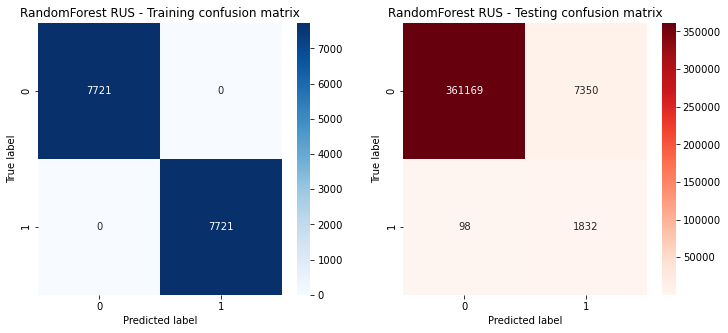

In [42]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_2a_train, annot=True, fmt = '', cmap = 'Blues',ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('RandomForest RUS - Training confusion matrix')

sns.heatmap(cm_2a_test, annot=True, fmt = '', cmap = 'Reds',ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('RandomForest RUS - Testing confusion matrix')

In [43]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_rus_np, y_pred_train_2a, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test_np, y_pred_test_2a, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00      7721
       fraud       1.00      1.00      1.00      7721

    accuracy                           1.00     15442
   macro avg       1.00      1.00      1.00     15442
weighted avg       1.00      1.00      1.00     15442

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      0.98      0.99    368519
       fraud       0.20      0.95      0.33      1930

    accuracy                           0.98    370449
   macro avg       0.60      0.96      0.66    370449
weighted avg       1.00      0.98      0.99    370449



Create dictionary versions of classification reports and add them to metrics dataframe

In [44]:
train_report_2a = classification_report(y_train_rus_np, y_pred_train_2a, target_names=target_names, output_dict = True)
test_report_2a = classification_report(y_test_np, y_pred_test_2a, target_names=target_names, output_dict = True)

add_metrics('Random Forest', 'Random Under Sampling', train_report_2a, test_report_2a)
metrics

,Algorithm,Class Balancing,Train Precision,Train Recall,Train f1,Train Support,Test Precision,Test Recall,Test f1,Test Support
0,Logistic Regression,Random Under Sampling,0.900475,0.860122,0.879836,7721,0.043136,0.859067,0.082146,1930
1,Logistic Regression,Random Over Sampling,0.897946,0.858799,0.877937,1474073,0.043753,0.854404,0.083243,1930
2,Logistic Regression,SMOTE,0.900986,0.863715,0.881957,1474073,0.045073,0.854922,0.085632,1930
3,Logistic Regression,Balanced weight,0.044084,0.858568,0.083862,7721,0.043811,0.854404,0.083348,1930
4,Random Forest,Random Under Sampling,1.000000,1.000000,1.000000,7721,0.199521,0.949223,0.329734,1930


### 2b) with Random Over Sampling

In [45]:
rf_ros = RandomForestClassifier(random_state=42)
rf_ros.fit(X_train_ros_np, y_train_ros_np)

y_pred_train_2b = rf_ros.predict(X_train_ros_np)
y_pred_test_2b = rf_ros.predict(X_test_np)

In [46]:
from sklearn.metrics import confusion_matrix
cm_2b_train = confusion_matrix(y_train_ros_np,y_pred_train_2b)
cm_2b_test = confusion_matrix(y_test_np,y_pred_test_2b)

Text(0.5, 1.0, 'RandomForest ROS - Testing confusion matrix')

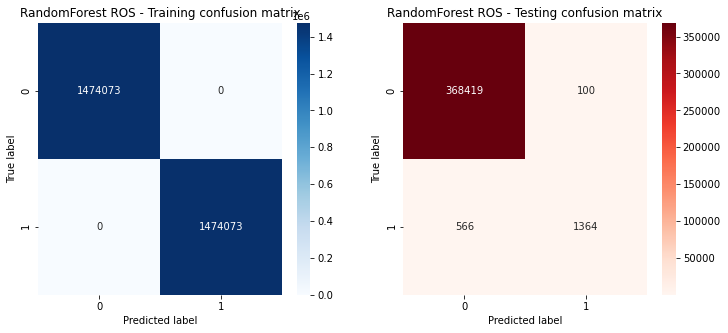

In [47]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_2b_train, annot=True, fmt = '', cmap = 'Blues',ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('RandomForest ROS - Training confusion matrix')

sns.heatmap(cm_2b_test, annot=True, fmt = '', cmap = 'Reds',ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('RandomForest ROS - Testing confusion matrix')

In [48]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_ros_np, y_pred_train_2b, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test_np, y_pred_test_2b, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00   1474073
       fraud       1.00      1.00      1.00   1474073

    accuracy                           1.00   2948146
   macro avg       1.00      1.00      1.00   2948146
weighted avg       1.00      1.00      1.00   2948146

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00    368519
       fraud       0.93      0.71      0.80      1930

    accuracy                           1.00    370449
   macro avg       0.97      0.85      0.90    370449
weighted avg       1.00      1.00      1.00    370449



Create dictionary versions of classification reports and add them to metrics dataframe

In [49]:
train_report_2b = classification_report(y_train_ros_np, y_pred_train_2b, target_names=target_names, output_dict = True)
test_report_2b = classification_report(y_test_np, y_pred_test_2b, target_names=target_names, output_dict = True)

add_metrics('Random Forest', 'Random Over Sampling', train_report_2b, test_report_2b)
metrics

,Algorithm,Class Balancing,Train Precision,Train Recall,Train f1,Train Support,Test Precision,Test Recall,Test f1,Test Support
0,Logistic Regression,Random Under Sampling,0.900475,0.860122,0.879836,7721,0.043136,0.859067,0.082146,1930
1,Logistic Regression,Random Over Sampling,0.897946,0.858799,0.877937,1474073,0.043753,0.854404,0.083243,1930
2,Logistic Regression,SMOTE,0.900986,0.863715,0.881957,1474073,0.045073,0.854922,0.085632,1930
3,Logistic Regression,Balanced weight,0.044084,0.858568,0.083862,7721,0.043811,0.854404,0.083348,1930
4,Random Forest,Random Under Sampling,1.000000,1.000000,1.000000,7721,0.199521,0.949223,0.329734,1930
5,Random Forest,Random Over Sampling,1.000000,1.000000,1.000000,1474073,0.931694,0.706736,0.803771,1930


### 2c) with SMOTE

In [50]:
rf_sm = RandomForestClassifier(random_state=42)
rf_sm.fit(X_train_sm_np, y_train_sm_np)

y_pred_train_2c = rf_sm.predict(X_train_sm_np)
y_pred_test_2c = rf_sm.predict(X_test_np)

In [51]:
cm_2c_train = confusion_matrix(y_train_sm_np,y_pred_train_2c)
cm_2c_test = confusion_matrix(y_test_np,y_pred_test_2c)

Text(0.5, 1.0, 'RandomForest SMOTE - Testing confusion matrix')

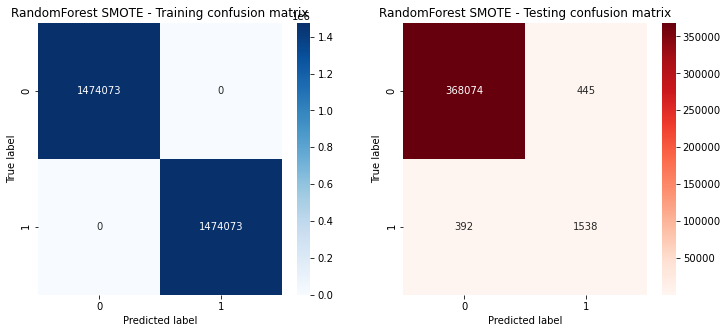

In [52]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_2c_train, annot=True, fmt = '', cmap = 'Blues',ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('RandomForest SMOTE - Training confusion matrix')

sns.heatmap(cm_2c_test, annot=True, fmt = '', cmap = 'Reds',ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('RandomForest SMOTE - Testing confusion matrix')

In [53]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_sm_np, y_pred_train_2c, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test_np, y_pred_test_2c, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00   1474073
       fraud       1.00      1.00      1.00   1474073

    accuracy                           1.00   2948146
   macro avg       1.00      1.00      1.00   2948146
weighted avg       1.00      1.00      1.00   2948146

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00    368519
       fraud       0.78      0.80      0.79      1930

    accuracy                           1.00    370449
   macro avg       0.89      0.90      0.89    370449
weighted avg       1.00      1.00      1.00    370449



Create dictionary versions of classification reports and add them to metrics dataframe

In [54]:
train_report_2c = classification_report(y_train_sm_np, y_pred_train_2c, target_names=target_names, output_dict = True)
test_report_2c = classification_report(y_test_np, y_pred_test_2c, target_names=target_names, output_dict = True)

add_metrics('Random Forest', 'SMOTE', train_report_2c, test_report_2c)
metrics

,Algorithm,Class Balancing,Train Precision,Train Recall,Train f1,Train Support,Test Precision,Test Recall,Test f1,Test Support
0,Logistic Regression,Random Under Sampling,0.900475,0.860122,0.879836,7721,0.043136,0.859067,0.082146,1930
1,Logistic Regression,Random Over Sampling,0.897946,0.858799,0.877937,1474073,0.043753,0.854404,0.083243,1930
2,Logistic Regression,SMOTE,0.900986,0.863715,0.881957,1474073,0.045073,0.854922,0.085632,1930
3,Logistic Regression,Balanced weight,0.044084,0.858568,0.083862,7721,0.043811,0.854404,0.083348,1930
4,Random Forest,Random Under Sampling,1.000000,1.000000,1.000000,7721,0.199521,0.949223,0.329734,1930
5,Random Forest,Random Over Sampling,1.000000,1.000000,1.000000,1474073,0.931694,0.706736,0.803771,1930
6,Random Forest,SMOTE,1.000000,1.000000,1.000000,1474073,0.775593,0.796891,0.786098,1930


### 2d) with class_weight = balanced

In [55]:
rf_cw = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_cw.fit(X_train_np, y_train_np)

y_pred_train_2d = rf_cw.predict(X_train_np)
y_pred_test_2d = rf_cw.predict(X_test_np)

In [56]:
cm_2d_train = confusion_matrix(y_train_np,y_pred_train_2d)
cm_2d_test = confusion_matrix(y_test_np,y_pred_test_2d)

Text(0.5, 1.0, 'RandomForest class_weight balanced - Testing confusion matrix')

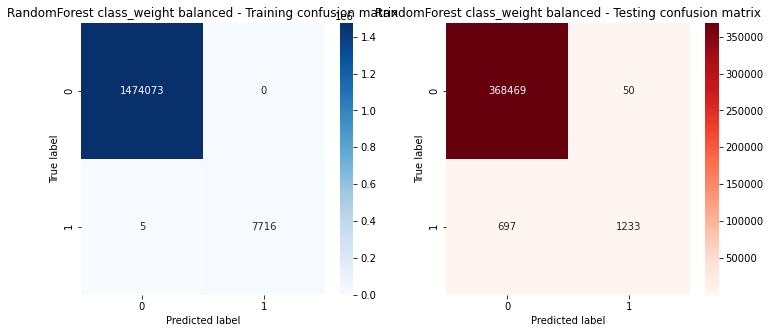

In [57]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_2d_train, annot=True, fmt = '', cmap = 'Blues',ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('RandomForest class_weight balanced - Training confusion matrix')

sns.heatmap(cm_2d_test, annot=True, fmt = '', cmap = 'Reds',ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('RandomForest class_weight balanced - Testing confusion matrix')

In [58]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_np, y_pred_train_2d, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test_np, y_pred_test_2d, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00   1474073
       fraud       1.00      1.00      1.00      7721

    accuracy                           1.00   1481794
   macro avg       1.00      1.00      1.00   1481794
weighted avg       1.00      1.00      1.00   1481794

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00    368519
       fraud       0.96      0.64      0.77      1930

    accuracy                           1.00    370449
   macro avg       0.98      0.82      0.88    370449
weighted avg       1.00      1.00      1.00    370449



Create dictionary versions of classification reports and add them to metrics dataframe

In [59]:
train_report_2d = classification_report(y_train_np, y_pred_train_2d, target_names=target_names, output_dict = True)
test_report_2d = classification_report(y_test_np, y_pred_test_2d, target_names=target_names, output_dict = True)

add_metrics('Random Forest', 'Balanced weight', train_report_2d, test_report_2d)
metrics

,Algorithm,Class Balancing,Train Precision,Train Recall,Train f1,Train Support,Test Precision,Test Recall,Test f1,Test Support
0,Logistic Regression,Random Under Sampling,0.900475,0.860122,0.879836,7721,0.043136,0.859067,0.082146,1930
1,Logistic Regression,Random Over Sampling,0.897946,0.858799,0.877937,1474073,0.043753,0.854404,0.083243,1930
2,Logistic Regression,SMOTE,0.900986,0.863715,0.881957,1474073,0.045073,0.854922,0.085632,1930
3,Logistic Regression,Balanced weight,0.044084,0.858568,0.083862,7721,0.043811,0.854404,0.083348,1930
4,Random Forest,Random Under Sampling,1.000000,1.000000,1.000000,7721,0.199521,0.949223,0.329734,1930
5,Random Forest,Random Over Sampling,1.000000,1.000000,1.000000,1474073,0.931694,0.706736,0.803771,1930
6,Random Forest,SMOTE,1.000000,1.000000,1.000000,1474073,0.775593,0.796891,0.786098,1930
7,Random Forest,Balanced weight,1.000000,0.999352,0.999676,7721,0.961029,0.638860,0.767507,1930


## Algorithm 3: XGBoost

In [60]:
import xgboost as xgb

### 3a) with Random Under Sampling

In [61]:
xg_rus = xgb.XGBClassifier(eval_metric = 'logloss', use_label_encoder=False, seed = 42)

xg_rus.fit(X_train_rus_np, y_train_rus_np)

y_pred_train_3a = xg_rus.predict(X_train_rus_np)
y_pred_test_3a = xg_rus.predict(X_test_np)

In [62]:
cm_3a_train = confusion_matrix(y_train_rus_np,y_pred_train_3a)
cm_3a_test = confusion_matrix(y_test_np,y_pred_test_3a)

Text(0.5, 1.0, 'XGBoost RUS - Testing confusion matrix')

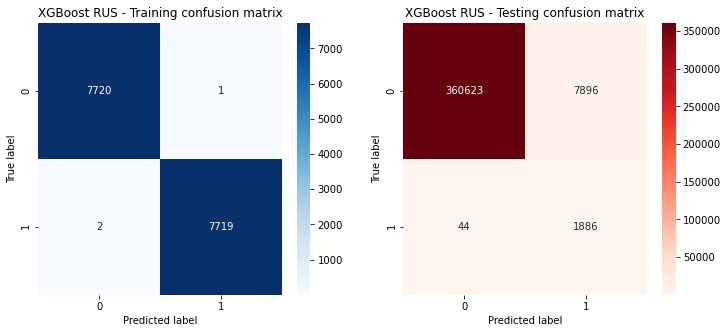

In [63]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_3a_train, annot=True, fmt = '', cmap = 'Blues',ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('XGBoost RUS - Training confusion matrix')

sns.heatmap(cm_3a_test, annot=True, fmt = '', cmap = 'Reds',ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('XGBoost RUS - Testing confusion matrix')

In [64]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_rus_np, y_pred_train_3a, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test_np, y_pred_test_3a, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00      7721
       fraud       1.00      1.00      1.00      7721

    accuracy                           1.00     15442
   macro avg       1.00      1.00      1.00     15442
weighted avg       1.00      1.00      1.00     15442

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      0.98      0.99    368519
       fraud       0.19      0.98      0.32      1930

    accuracy                           0.98    370449
   macro avg       0.60      0.98      0.66    370449
weighted avg       1.00      0.98      0.99    370449



In [65]:
train_report_3a = classification_report(y_train_rus_np, y_pred_train_3a, target_names=target_names, output_dict = True)
test_report_3a = classification_report(y_test_np, y_pred_test_3a, target_names=target_names, output_dict = True)

add_metrics('XGBoost', 'Random Under Sampling', train_report_3a, test_report_3a)
metrics

,Algorithm,Class Balancing,Train Precision,Train Recall,Train f1,Train Support,Test Precision,Test Recall,Test f1,Test Support
0,Logistic Regression,Random Under Sampling,0.900475,0.860122,0.879836,7721,0.043136,0.859067,0.082146,1930
1,Logistic Regression,Random Over Sampling,0.897946,0.858799,0.877937,1474073,0.043753,0.854404,0.083243,1930
2,Logistic Regression,SMOTE,0.900986,0.863715,0.881957,1474073,0.045073,0.854922,0.085632,1930
3,Logistic Regression,Balanced weight,0.044084,0.858568,0.083862,7721,0.043811,0.854404,0.083348,1930
4,Random Forest,Random Under Sampling,1.000000,1.000000,1.000000,7721,0.199521,0.949223,0.329734,1930
5,Random Forest,Random Over Sampling,1.000000,1.000000,1.000000,1474073,0.931694,0.706736,0.803771,1930
6,Random Forest,SMOTE,1.000000,1.000000,1.000000,1474073,0.775593,0.796891,0.786098,1930
7,Random Forest,Balanced weight,1.000000,0.999352,0.999676,7721,0.961029,0.638860,0.767507,1930
8,XGBoost,Random Under Sampling,0.999870,0.999741,0.999806,7721,0.192803,0.977202,0.322063,1930


### 3b) with Random Over Sampling

In [66]:
xg_ros = xgb.XGBClassifier(eval_metric = 'logloss', use_label_encoder=False, seed = 42)

xg_ros.fit(X_train_ros_np, y_train_ros_np)

y_pred_train_3b = xg_ros.predict(X_train_ros_np)
y_pred_test_3b = xg_ros.predict(X_test_np)

In [67]:
cm_3b_train = confusion_matrix(y_train_ros_np,y_pred_train_3b)
cm_3b_test = confusion_matrix(y_test_np,y_pred_test_3b)

Text(0.5, 1.0, 'XGBoost ROS - Testing confusion matrix')

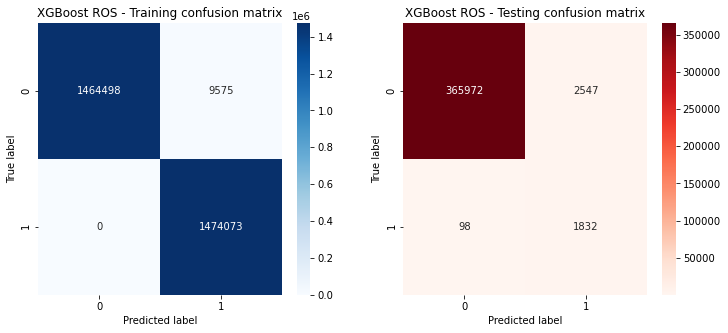

In [68]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_3b_train, annot=True, fmt = '', cmap = 'Blues',ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('XGBoost ROS - Training confusion matrix')

sns.heatmap(cm_3b_test, annot=True, fmt = '', cmap = 'Reds',ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('XGBoost ROS - Testing confusion matrix')

In [69]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_ros_np, y_pred_train_3b, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test_np, y_pred_test_3b, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       1.00      0.99      1.00   1474073
       fraud       0.99      1.00      1.00   1474073

    accuracy                           1.00   2948146
   macro avg       1.00      1.00      1.00   2948146
weighted avg       1.00      1.00      1.00   2948146

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      0.99      1.00    368519
       fraud       0.42      0.95      0.58      1930

    accuracy                           0.99    370449
   macro avg       0.71      0.97      0.79    370449
weighted avg       1.00      0.99      0.99    370449



In [70]:
train_report_3b = classification_report(y_train_ros_np, y_pred_train_3b, target_names=target_names, output_dict = True)
test_report_3b = classification_report(y_test_np, y_pred_test_3b, target_names=target_names, output_dict = True)

add_metrics('XGBoost', 'Random Over Sampling', train_report_3b, test_report_3b)
metrics

,Algorithm,Class Balancing,Train Precision,Train Recall,Train f1,Train Support,Test Precision,Test Recall,Test f1,Test Support
0,Logistic Regression,Random Under Sampling,0.900475,0.860122,0.879836,7721,0.043136,0.859067,0.082146,1930
1,Logistic Regression,Random Over Sampling,0.897946,0.858799,0.877937,1474073,0.043753,0.854404,0.083243,1930
2,Logistic Regression,SMOTE,0.900986,0.863715,0.881957,1474073,0.045073,0.854922,0.085632,1930
3,Logistic Regression,Balanced weight,0.044084,0.858568,0.083862,7721,0.043811,0.854404,0.083348,1930
4,Random Forest,Random Under Sampling,1.000000,1.000000,1.000000,7721,0.199521,0.949223,0.329734,1930
5,Random Forest,Random Over Sampling,1.000000,1.000000,1.000000,1474073,0.931694,0.706736,0.803771,1930
6,Random Forest,SMOTE,1.000000,1.000000,1.000000,1474073,0.775593,0.796891,0.786098,1930
7,Random Forest,Balanced weight,1.000000,0.999352,0.999676,7721,0.961029,0.638860,0.767507,1930
8,XGBoost,Random Under Sampling,0.999870,0.999741,0.999806,7721,0.192803,0.977202,0.322063,1930
9,XGBoost,Random Over Sampling,0.993546,1.000000,0.996763,1474073,0.418360,0.949223,0.580758,1930


### 3c) with SMOTE

In [71]:
xg_sm = xgb.XGBClassifier(eval_metric = 'logloss', use_label_encoder=False, seed = 42)
xg_sm.fit(X_train_sm_np, y_train_sm_np)

y_pred_train_3c = xg_sm.predict(X_train_sm_np)
y_pred_test_3c = xg_sm.predict(X_test_np)

In [72]:
cm_3c_train = confusion_matrix(y_train_sm_np,y_pred_train_3c)
cm_3c_test = confusion_matrix(y_test_np,y_pred_test_3c)

Text(0.5, 1.0, 'XGBoost SMOTE - Testing confusion matrix')

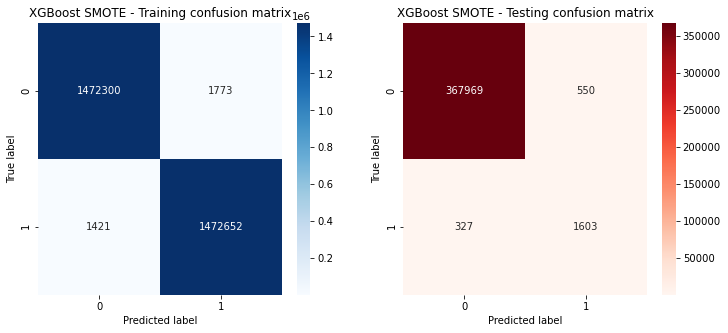

In [73]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_3c_train, annot=True, fmt = '', cmap = 'Blues',ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('XGBoost SMOTE - Training confusion matrix')

sns.heatmap(cm_3c_test, annot=True, fmt = '', cmap = 'Reds',ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('XGBoost SMOTE - Testing confusion matrix')

In [74]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_sm_np, y_pred_train_3c, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test_np, y_pred_test_3c, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00   1474073
       fraud       1.00      1.00      1.00   1474073

    accuracy                           1.00   2948146
   macro avg       1.00      1.00      1.00   2948146
weighted avg       1.00      1.00      1.00   2948146

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00    368519
       fraud       0.74      0.83      0.79      1930

    accuracy                           1.00    370449
   macro avg       0.87      0.91      0.89    370449
weighted avg       1.00      1.00      1.00    370449



In [75]:
train_report_3c = classification_report(y_train_sm_np, y_pred_train_3c, target_names=target_names, output_dict = True)
test_report_3c = classification_report(y_test_np, y_pred_test_3c, target_names=target_names, output_dict = True)

add_metrics('XGBoost', 'SMOTE', train_report_3c, test_report_3c)
metrics

,Algorithm,Class Balancing,Train Precision,Train Recall,Train f1,Train Support,Test Precision,Test Recall,Test f1,Test Support
0,Logistic Regression,Random Under Sampling,0.900475,0.860122,0.879836,7721,0.043136,0.859067,0.082146,1930
1,Logistic Regression,Random Over Sampling,0.897946,0.858799,0.877937,1474073,0.043753,0.854404,0.083243,1930
2,Logistic Regression,SMOTE,0.900986,0.863715,0.881957,1474073,0.045073,0.854922,0.085632,1930
3,Logistic Regression,Balanced weight,0.044084,0.858568,0.083862,7721,0.043811,0.854404,0.083348,1930
4,Random Forest,Random Under Sampling,1.000000,1.000000,1.000000,7721,0.199521,0.949223,0.329734,1930
5,Random Forest,Random Over Sampling,1.000000,1.000000,1.000000,1474073,0.931694,0.706736,0.803771,1930
6,Random Forest,SMOTE,1.000000,1.000000,1.000000,1474073,0.775593,0.796891,0.786098,1930
7,Random Forest,Balanced weight,1.000000,0.999352,0.999676,7721,0.961029,0.638860,0.767507,1930
8,XGBoost,Random Under Sampling,0.999870,0.999741,0.999806,7721,0.192803,0.977202,0.322063,1930
9,XGBoost,Random Over Sampling,0.993546,1.000000,0.996763,1474073,0.418360,0.949223,0.580758,1930


### 3d) with class_weight = balanced

We will use the "scale_pos_weight" parameter of the XGBClassifier to train a class weighted version of XGboost for imbalanced classification.  A reasonable way to scale the positive class is to use the total number of examples in the majority class divided by the total number of examples in the minority class.

In [76]:
uniqueValues, occurCount = np.unique(y_train_np, return_counts=True)
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)

Unique Values :  [0 1]
Occurrence Count :  [1474073    7721]


In [77]:
weight = occurCount[0] / occurCount[1]
weight = round(weight)
weight

191

In [78]:
xg_cw = xgb.XGBClassifier(eval_metric = 'logloss', use_label_encoder=False, scale_pos_weight = weight, seed = 42)
xg_cw.fit(X_train_np, y_train_np)

y_pred_train_3d = xg_cw.predict(X_train_np)
y_pred_test_3d = xg_cw.predict(X_test_np)

In [79]:
cm_3d_train = confusion_matrix(y_train_np,y_pred_train_3d)
cm_3d_test = confusion_matrix(y_test_np,y_pred_test_3d)

Text(0.5, 1.0, 'XGBoost SMOTE - Testing confusion matrix')

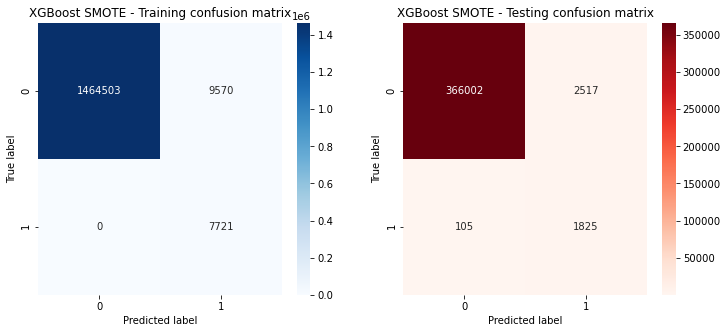

In [80]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_3d_train, annot=True, fmt = '', cmap = 'Blues',ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('XGBoost SMOTE - Training confusion matrix')

sns.heatmap(cm_3d_test, annot=True, fmt = '', cmap = 'Reds',ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('XGBoost SMOTE - Testing confusion matrix')

In [81]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_np, y_pred_train_3d, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test_np, y_pred_test_3d, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       1.00      0.99      1.00   1474073
       fraud       0.45      1.00      0.62      7721

    accuracy                           0.99   1481794
   macro avg       0.72      1.00      0.81   1481794
weighted avg       1.00      0.99      0.99   1481794

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      0.99      1.00    368519
       fraud       0.42      0.95      0.58      1930

    accuracy                           0.99    370449
   macro avg       0.71      0.97      0.79    370449
weighted avg       1.00      0.99      0.99    370449



In [82]:
train_report_3d = classification_report(y_train_np, y_pred_train_3d, target_names=target_names, output_dict = True)
test_report_3d = classification_report(y_test_np, y_pred_test_3d, target_names=target_names, output_dict = True)

add_metrics('XGBoost', 'Balanced weight', train_report_3d, test_report_3d)
metrics

,Algorithm,Class Balancing,Train Precision,Train Recall,Train f1,Train Support,Test Precision,Test Recall,Test f1,Test Support
0,Logistic Regression,Random Under Sampling,0.900475,0.860122,0.879836,7721,0.043136,0.859067,0.082146,1930
1,Logistic Regression,Random Over Sampling,0.897946,0.858799,0.877937,1474073,0.043753,0.854404,0.083243,1930
2,Logistic Regression,SMOTE,0.900986,0.863715,0.881957,1474073,0.045073,0.854922,0.085632,1930
3,Logistic Regression,Balanced weight,0.044084,0.858568,0.083862,7721,0.043811,0.854404,0.083348,1930
4,Random Forest,Random Under Sampling,1.000000,1.000000,1.000000,7721,0.199521,0.949223,0.329734,1930
5,Random Forest,Random Over Sampling,1.000000,1.000000,1.000000,1474073,0.931694,0.706736,0.803771,1930
6,Random Forest,SMOTE,1.000000,1.000000,1.000000,1474073,0.775593,0.796891,0.786098,1930
7,Random Forest,Balanced weight,1.000000,0.999352,0.999676,7721,0.961029,0.638860,0.767507,1930
8,XGBoost,Random Under Sampling,0.999870,0.999741,0.999806,7721,0.192803,0.977202,0.322063,1930
9,XGBoost,Random Over Sampling,0.993546,1.000000,0.996763,1474073,0.418360,0.949223,0.580758,1930


## Summary and next steps:

In total, we've trained 12 'vanilla' models thus far combining an algorithm with a resampling (or class weight balancing) method. If we wanted to optimize recall, then the top two models would be XGBoost with random under sampling and XGBoost with random oversampling.  Unfortunately these two models have low precision values that are concerning to the potential business client.  In other words, while these models are able to capture a high percentage of the actual fraud cases, it also mislabels a significant number of valid transactions as fraudulent.

Taking a look at the f1-score, our top three models are:

<b>1. Random Forest with random over sampling </b>

<b>2. Random Forest with SMOTE</b>

<b>3. XGBoost with SMOTE</b>

In the next notebok, we will apply hyperparameter tuning to these three models to see if we can see any further improvements and decide on our model from there.  We'll save our resampled datasets to use in the next notebook.

In [83]:
X_train_rus.to_csv('../raw_data/X_train_rus.csv')
y_train_rus.to_csv('../raw_data/y_train_rus.csv')
X_train_ros.to_csv('../raw_data/X_train_ros.csv')
y_train_ros.to_csv('../raw_data/y_train_ros.csv')
X_train_sm.to_csv('../raw_data/X_train_sm.csv')
y_train_sm.to_csv('../raw_data/y_train_sm.csv')

In [84]:
metrics.to_csv('../raw_data/metrics.csv')